## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [133]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет тип object

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [135]:
data['date'] = pd.to_datetime(data['date'])
data_check_date = data.groupby('group')['date'].agg(['min', 'max'])
display(data_check_date)


,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


A/B тест проводился в промежуток времени с 2 по 24 января 2021 года

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [136]:
print('Количество посещений в группах А и В: ')
display(data.groupby('group')['user_id'].count())

print('Суммарное количество покупок группах А и В: ')
display(data.groupby('group')['purchase'].sum())

print('Сумма всех покупок группах А и В, в млн.руб.: ')
display(data.groupby('group')['price'].sum()/1000000)

Количество посещений в группах А и В: 


group
A    147202
B    147276
Name: user_id, dtype: int64

Суммарное количество покупок группах А и В: 


group
A    17723
B    17514
Name: purchase, dtype: int64

Сумма всех покупок группах А и В, в млн.руб.: 


group
A    1436.26
B    1554.10
Name: price, dtype: float64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [137]:
group_a_users = data[data['group'] == 'A']['user_id']
group_b_users = data[data['group'] == 'B']['user_id']
users_intersection = set(group_a_users).intersection(set(group_b_users))
print('Количество пользователей, которые попали в обе группы в процессе A/B теста: ', len(users_intersection))

Количество пользователей, которые попали в обе группы в процессе A/B теста:  1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [138]:
updated_data = data[data['user_id'].apply(lambda x: x not in users_intersection)]
display(updated_data.head())

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

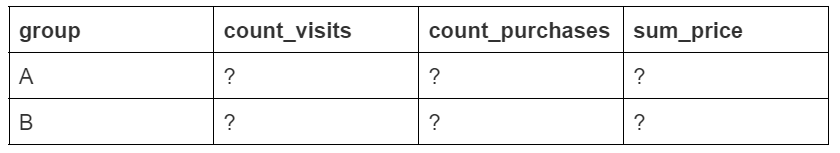
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [156]:
grouped_data = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index()
grouped_data = grouped_data.rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

display(grouped_data)

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

В общем и целом количество посещений обоих вариантов посадочной страницы сопоставимо. Количество посещений в группе А составляет 145 307 человек, а в группе В - 145 381 человек. Конечно, можно было бы обеспечить равное количество посещений для двух вариантов, но, учитывая сложности с распределением на группы, можно говорить о сбалансированности двух данных выборок.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [140]:
grouped_data['conversion'] = grouped_data['count_purchases'] / grouped_data['count_visits'] * 100
grouped_data['mean_check'] = grouped_data['sum_price'] / grouped_data['count_purchases']
display(grouped_data)

print('Конверсия в группах А и B равна, в %:')
display(grouped_data['conversion'].round(2))
print('\n Средний чек в группах А и B равен, в руб.:')
display(grouped_data['mean_check'].round())

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Конверсия в группах А и B равна, в %:


0    12.03
1    11.89
Name: conversion, dtype: float64


 Средний чек в группах А и B равен, в руб.:


0    81076.0
1    88665.0
Name: mean_check, dtype: float64

Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Согласно данным по конверсии покупки и среднему чеку в группах А и В, можно сделать следующие выводы. Так, вариант А эффективнее варианта В по показателю конверсии покупки (12.03% > 11.89% соответственно), а вариант В в свою очередь эффективнее варинта А по показателю среднего чека (88 665 руб. > 81 076 руб. соответственно).

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [141]:
piv_table = updated_data[updated_data['price'] > 0].pivot_table(values='purchase', index='group', columns='price', aggfunc='sum')
piv_table

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Тепловая карта покупательской способности туров в группах А и В')

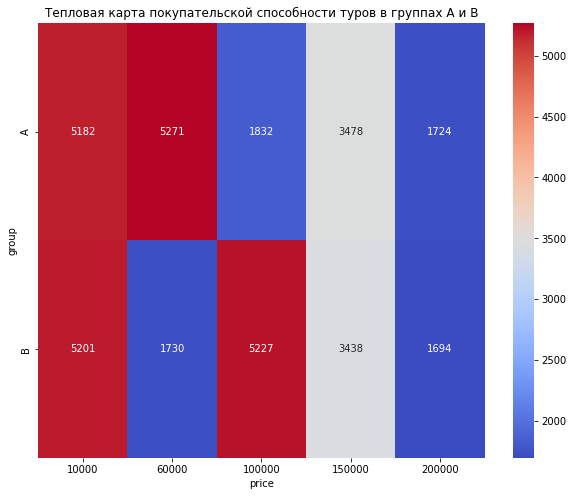

In [142]:
fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(piv_table, annot=True, fmt='.0f', cmap= 'coolwarm')
ax.set_title('Тепловая карта покупательской способности туров в группах А и В')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Анализируя тепловую карту покупательской способности туров в контрольной и тестовой группах, можно сделать следующие выводы. По туру стоимостью 60 тыс.руб. (Турция) покупательская способность существенно выше в группе А. Также покупательская способность незначительно выше у участников группы А в турах стоимостью 150 тыс.руб. (Камчатка) и 200 тыс.руб.(Мальдивы). Грубо оценивая, можно назвать туры на Камчатку и Мальдивы равнозначными по покупальской способности участников групп А и В. В то же время покупательская способность определенно выше в группе В по туру стоимостью 100 тыс.руб.(Таиланд). Также покупательская способность в группе В назначительно выше по туру стоимстью 10 тыс.руб. (Санкт-Петербург) - можно считать данный тур равнозначным по покупательской способности у участников контрольной и тестовой групп.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [143]:
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})
daily_data['conversion'] = daily_data['count_purchases'] / daily_data['count_visits'] * 100
daily_data['mean_check'] = daily_data['sum_price'] / daily_data['count_purchases']

print('Конверсия на 3 января 2021 года в группах А и В соответственно равна, в %: ')
display(daily_data[daily_data['date'] == '2021-01-03'][['group', 'conversion']].round(2))

print('Cредний чек на 3 января 2021 года в группах А и В соответственно равен, в руб.: ')
display(daily_data[daily_data['date'] == '2021-01-03'][['group', 'mean_check']].round())

Конверсия на 3 января 2021 года в группах А и В соответственно равна, в %: 


,group,conversion
2,A,11.34
3,B,11.39


Cредний чек на 3 января 2021 года в группах А и В соответственно равен, в руб.: 


,group,mean_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [144]:
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum()

daily_data['cum_conversion'] = daily_data['cum_count_purchases'] / daily_data['cum_count_visits'] * 100
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_count_purchases']

print('Кумулятивная конверсия в группе B на 20 января 2021 года равна, в % :')
display(daily_data[(daily_data['date'] == '2021-01-20') & (daily_data['group'] == 'B')]['cum_conversion'].round(2))

print('Кумулятивный средний чек в группе А на 12 января 2021 года равен, в руб.:')
display(daily_data[(daily_data['date'] == '2021-01-12') & (daily_data['group'] == 'A')]['cum_mean_check'].round())

Кумулятивная конверсия в группе B на 20 января 2021 года равна, в % :


37    11.9
Name: cum_conversion, dtype: float64

Кумулятивный средний чек в группе А на 12 января 2021 года равен, в руб.:


20    81492.0
Name: cum_mean_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

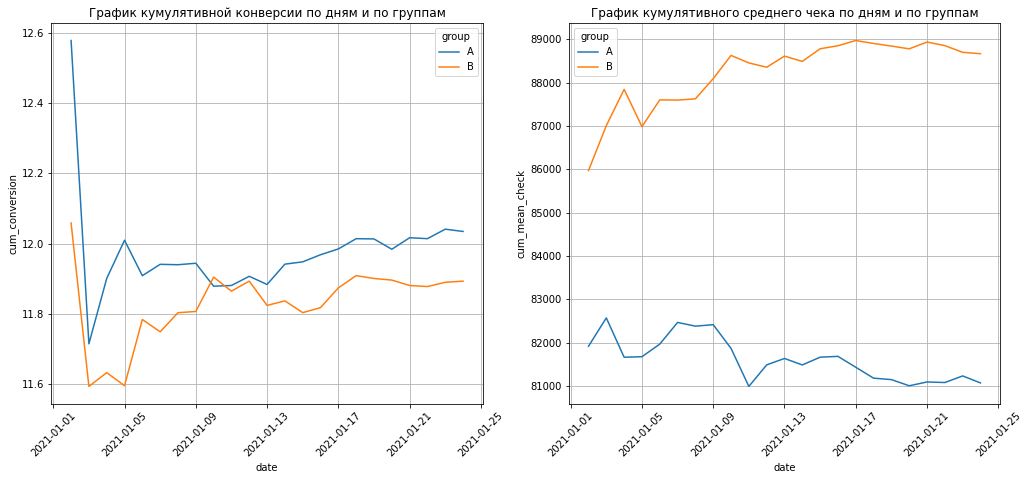

In [145]:
fig, axes= plt.subplots(1, 2, figsize=(17, 7))
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=axes[1])

axes[0].set_title('График кумулятивной конверсии по дням и по группам')
axes[1].set_title('График кумулятивного среднего чека по дням и по группам')

axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)

axes[0].grid(True);
axes[1].grid(True);

Анализируя линейные графики кумулятивной конверсии и кумулятивного среднего чека, можно сделать следующие выводы.
Во-первых, примерно до 09 января 2021 г. графики кумулятивной конверсии в группах А и В колебались и были нестабильны, но, начиная с 13 января 2021 г., скачки прекратились и линии постепенно выровнялись. Графики кумулятивного среднего чека в группах А и В также колебались до 13 января 2021 г., и далее стабилизировались в динамике. То есть A/B-тест можно считать завершённым, потому что значения рассматриваемых метрик во времени стабилизировались.
Во-вторых, судя по первому графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. Однако исходя из второго графика, можно утверждать об обратном: кумулятивный средний чек группы В стабильно лучше кумулятивного среднего чека группы А на всём промежутке времени.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

Применим Z-тест для пропорци для проверки гипотезы о равенстве конверсий в группах

In [146]:
converted_piv = updated_data.groupby('group')['purchase'].agg(['sum', 'count'])
converted_piv

,sum,count
group,,
A,17487,145307
B,17290,145381


In [147]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

 Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны с уровнем значимости 0.05, то полученная разница в метрике в группах статистически не значима. Говоря на языке бизнеса: разницы между вариантами посадочной страницы официального сайта компании нет — они одинаково эффективны по метрике конверсии.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [148]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [149]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Можно сделать вывод, что с надёжностью в 95% конверсия группы А лежит в интервале от 11.87% до 12.2%, а конверсия группы B лежит в интервале от 11.73% до 12.06%. Также существует перекрытие между доверительными интервалами для групп А и В - интервал перекрытия (11.87, 12.06). Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть. То есть на основании доверительных интевалов для каждой группы нельзя однозначно сказать, есть ли разница в конверсиях. Однако на основании результатов расчёта доверительного интервала разницы конверсий в группах, можно сделать вывод о том, что варианты А и B равнозначны по метрике конверсии, поскольку левая граница доверительного интервала отрицательная, а правая — положительная. То есть статистически значимой разницы между конверсиями в группах А и Б нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [150]:
daily_data.head()

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


In [151]:
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']

# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


В результате проведения теста Шапиро-Уилка, можно сделать вывод, что распределение ежедневного среднего чека нормальное в обеих группах 

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [152]:
print('Количество объектов в выборке группы А: ', len(daily_data_a))
print('Количество объектов в выборке группы B: ', len(daily_data_b)) 


Количество объектов в выборке группы А:  23
Количество объектов в выборке группы B:  23


In [153]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_data_a['mean_check'],
    b=daily_data_b['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Для проверки гипотезы о равенстве средних чеков по дням в группах используется T-тест, так как количество объектов в каждой выборке равно 23.
На основании результата T-теста получено, что p-value: 0.0 меньше уровня значимости альфа: 0.05, а это значит нулевая гипотеза о равенстве средних чеков в группах А и В отвергается и принимается альтернативная гипотеза, заключающаяся в том, что ежедневный средний чек в группе А меньше чем в группе B. Иначе говоря, с заданным уровнем значимости альфа 0.05 можно говорить о наличии статистически значимой разницы между ежедневными средними чеками в группах А и Б. Отсюда можно сделать вывод, что вариант А посадочной страницы официального сайта компании хуже, следовательно выриант В лучше. 

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [154]:
def conf_interval_with_unknown_std(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std/(n ** 0.5) #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
params_a = {
    'n': daily_data_a['count_visits'].count(), # размер выборки
    'x_mean': daily_data_a['mean_check'].mean(), # выборочное средние
    'x_std': daily_data_a['mean_check'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': daily_data_b['count_visits'].count(),# размер выборки
    'x_mean': daily_data_b['mean_check'].mean(), # выборочное средние
    'x_std': daily_data_b['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(conf_interval_with_unknown_std(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(conf_interval_with_unknown_std(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Можно сделать вывод, что с надёжностью в 95% истинный средний чек группы А лежит в интервале от 79 630 до 82 308 руб., а истинный средний чек группы B лежит в интервале от 87 626 руб. до 89 526 руб. Между данными доверительными интервалами для групп А и В пересечение отсутствует. Это значит, что истинные значения средних чеков в обеих группах не могут совпасть. То есть на основании доверительных интевалов для каждой группы можно сказать, есть статистически значимая разница - доверительный интервал для группы А меньше, чем доверительный интервал группы В, а значит истинное среднее в группе А меньше, чем истинное среднее в группе В. 

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

По результатам проведенного А/В теста можно сделать следующий вывод - вариант В дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека. Это обусловливается тем, что, во-первых, нет статистически значимой разницы между конверсиями в группах А и Б. Данный результат был получен в результате проведения z-теста для пропорций и построения доверительных интервалов для пропорций. Во-вторых, на основании проведенного T-теста и построения доверительных интервалов было установлено, что разница между ежедневными средними чеками в группах А и B статистически значима и истинный ежедневний средний чек в группе В больше истинного ежедневного среднего чека в группе А с заданными уровнями значимости и надежности. Таким образом, если по метрике конверсии нет разницы между вариантами А и В, а по среднему чеку разница есть, и она существует в пользу варианта В, то для туристической фирмы, целью которой как комерческой организации является получение прибыли, будет целесообразно внедрение варианта В дизайна посадочной страницы. Это позволит компаниии добиться большей выручки, а значит и чистой прибыли. 